# Download counts for nteract

In [1]:
import IPython.display
import pandas as pd

/Users/tomb/papermill/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/tomb/papermill/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
import requests

# Note: 
data = requests.get('https://api.github.com/repos/nteract/nteract/releases').json()

In [3]:
print("{}:\n\t{}\n\t{}".format(
  data[0]['tag_name'],
  data[0]['assets'][0]['browser_download_url'],
  data[0]['assets'][0]['download_count']
))


v0.10.0:
	https://github.com/nteract/nteract/releases/download/v0.10.0/latest-linux.yml
	363


The releases API only has context of the filename, so we'll convert:

```
https://github.com/nteract/nteract/releases/download/v0.0.13/nteract-darwin-x64.zip
```

to

```
darwin-x64
```

Which means we're reliant on our release naming to keep this a nice consistent structure

In [4]:
def strip_off_release(browser_download_url):
    filename = browser_download_url.split('/')[-1]
    basename = filename.split('.')[0]
    system = basename.split('-')[1:]
    return "-".join(system)

In [5]:
releases = [
  {
    'version': x['tag_name'], 
    'counts': { strip_off_release(y['browser_download_url']): y['download_count'] for y in x['assets'] }
  } 
    for x in data
]
releases

[{'version': 'v0.10.0',
  'counts': {'linux': 363, 'mac': 2279, '': 116, '0': 2, 'setup-0': 0}},
 {'version': 'v0.9.1',
  'counts': {'linux': 528, 'mac': 3390, '': 120, '0': 10, 'setup-0': 6}},
 {'version': 'v0.9.0',
  'counts': {'linux': 71, 'mac': 1300, '': 110, '0': 4, 'setup-0': 1}},
 {'version': 'v0.8.4',
  'counts': {'linux': 2466, 'mac': 14277, '': 335, '0': 61, 'setup-0': 16}},
 {'version': 'v0.8.3',
  'counts': {'linux': 159, 'mac': 1039, '': 106, '0': 3, 'setup-0': 1}},
 {'version': 'v0.8.0',
  'counts': {'linux': 40, 'mac': 239, '': 62, '0': 1, 'setup-0': 1}},
 {'version': 'v0.7.1',
  'counts': {'linux': 665, 'mac': 4531, '': 2, '0': 26, 'setup-0': 9}},
 {'version': 'v0.7.0',
  'counts': {'linux': 67, 'mac': 470, '': 2, '0': 1, 'setup-0': 1}},
 {'version': 'v0.6.2',
  'counts': {'linux': 328, 'mac': 1883, '': 6, '0': 8, 'setup-0': 7}},
 {'version': 'v0.6.1',
  'counts': {'linux': 1, 'mac': 3, '': 3, '0': 1, 'setup-0': 1}},
 {'version': 'v0.6.0',
  'counts': {'linux': 11, 'ma

In [6]:
versions = []
frames = []

for release in releases:
    versions.append(release['version'])
    frames.append(pd.DataFrame.from_dict(release['counts'], orient='index'))

df = pd.concat(frames, keys=versions).reset_index()
df.columns = ['version', 'os', 'count']
df['os'] = df.os.replace('os-x', 'darwin-x64')
df

,version,os,count
0,v0.10.0,linux,363
1,v0.10.0,mac,2279
2,v0.10.0,,116
3,v0.10.0,0,2
4,v0.10.0,setup-0,0
5,v0.9.1,linux,528
6,v0.9.1,mac,3390
7,v0.9.1,,120
8,v0.9.1,0,10
9,v0.9.1,setup-0,6


It would be really interesting to know how these counts change over time.

In [7]:
from distutils.version import LooseVersion

versions = set(df.version.values.tolist())
versions = sorted(versions, key=LooseVersion)

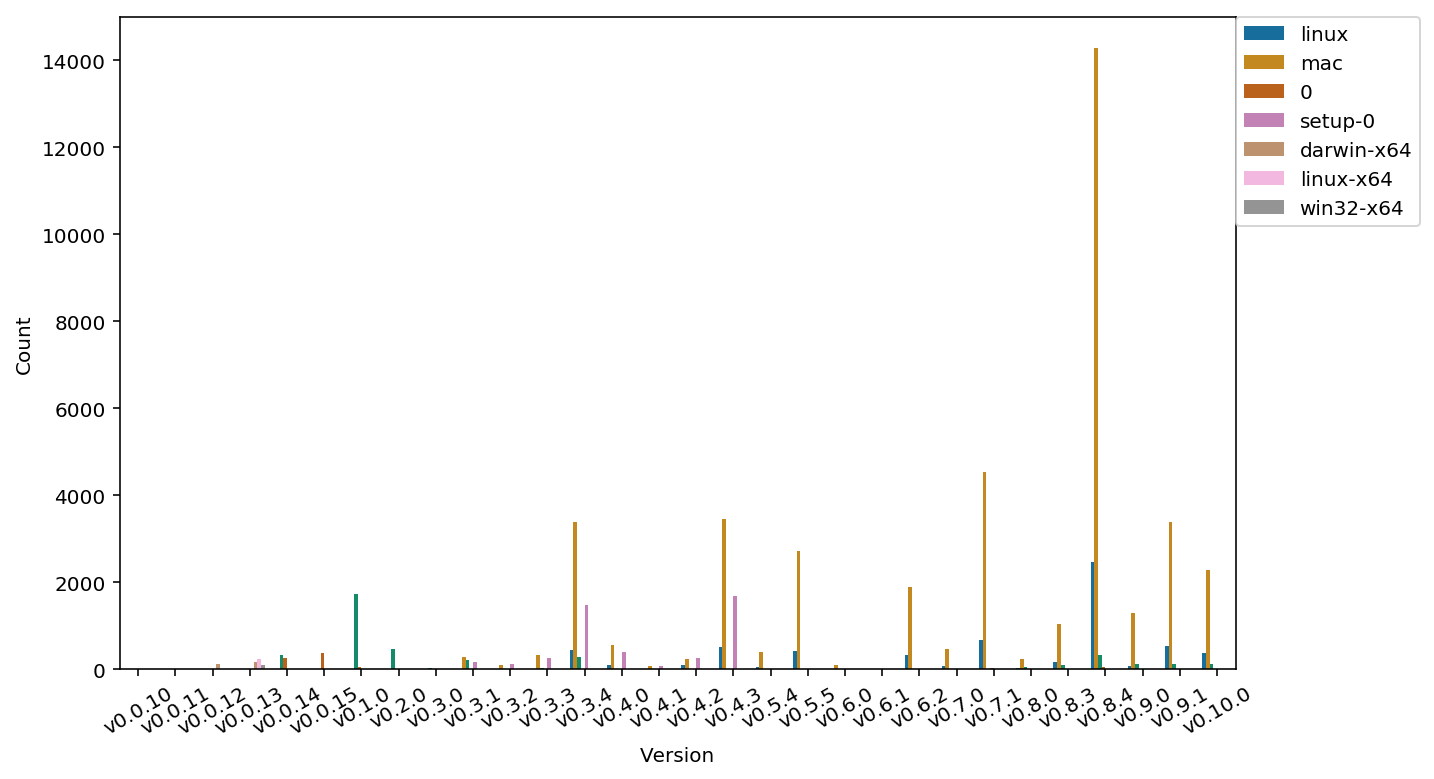

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

with sns.color_palette("colorblind", len(versions)):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax = sns.barplot(x='version', y="count", hue="os", data=df, order=versions)
    ax.set_xticklabels(versions, rotation=30)
    ax.set(xlabel='Version', ylabel='Count')
    plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0)
    plt.show()